# Data analysis

### Here we provide a dataset analysis. 
To better understand the defect classes, now we highlight them in the data set.

In [1]:
# import useful packages
import pandas as pd;
import numpy as np;

Import the dataset:

In [2]:
train_set = pd.read_csv('./../../data/training_set.csv').replace(np.nan, '', regex=True);
cv_set = pd.read_csv('./../../data/cross_validation_set.csv').replace(np.nan, '', regex=True);
test_set = pd.read_csv('./../../data/test_set.csv').replace(np.nan, '', regex=True);

To better understand the defect classes, we now analize a sample image.

In [3]:
n_defect_classes = 4;
defect_class_colors = [(208,2,27), (74,144,226), (126,211,33), (245,166,35)]; # 4 classes
defect_class_colors_01 = [[r / 255, g / 255, b / 255] for [r, g, b] in defect_class_colors]; # range 0-1

In [4]:
from PIL import Image, ImageDraw;
from IPython.display import Image as DisplayImage, display;
import numpy as np;
import math;

image_in = './../../data/train_images/{}';
image_out = './../../data/manipulated_images/defects/{}';

Let's consider at the beginning a sample image:

Image details:
JPEG
RGB
(1600, 256)


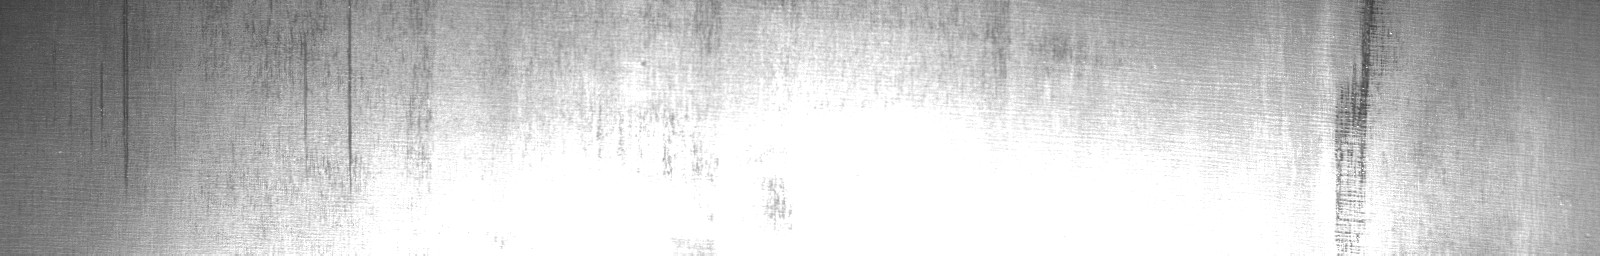

In [5]:
sample_image = train_set.iloc[91];
sample_image_id = sample_image['ImageId'];
 
image = Image.open(image_in.format(sample_image_id));
# summarize some details about the image
print('Image details:')
print(image.format)
print(image.mode)
print(image.size)
# show the image
DisplayImage(filename = image_in.format(sample_image_id), width = image.size[0], height = image.size[1])

We will now highlight its defects.

In [6]:
def decode_encoded_pixels(encoded_pixels_str, image_width, image_height):
    encoded_pixels = np.fromstring(encoded_pixels_str, dtype=int, count=-1, sep=' ');
    assert len(encoded_pixels) % 2 == 0, 'Must contain an even number of integers';
    x = []; y = [];
    for i in range(0, int(len(encoded_pixels) / 2)):
        starting_pixel = encoded_pixels[2 * i];
        n_pixels = encoded_pixels[2 * i + 1];
        for j in range(0, n_pixels):
            current_pixel = starting_pixel + j;
            x.append(math.floor(current_pixel / image_height));
            y.append(current_pixel % image_height);
    return (x, y);

In [7]:
import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
def alpha_shape(points, alpha = 0.5):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    It calculates a Delaunay triangulation of the 
    set of points and keeps only the triangles with 
    a circumscribe circle radius less the 1 / alpha.
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if not (i, j) in edges and not (j, i) in edges:
            edges.add( (i, j) );
            edge_points.append(coords[ [i, j] ]); # append the two vertices of the edge
    coords = np.array([point.coords[0] for point in points]);
    tri = Delaunay(coords);
    edges = set();
    edge_points = [];
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia];
        pb = coords[ib];
        pc = coords[ic];
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2);
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2);
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2);
        s = (a + b + c) / 2.0 # Semiperimeter of triangle
        area = math.sqrt(s*(s-a)*(s-b)*(s-c)); # Area of triangle by Heron's formula
        circum_r = a*b*c / (4.0*area);
        # radius filtering:
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib);
            add_edge(edges, edge_points, coords, ib, ic);
            add_edge(edges, edge_points, coords, ic, ia);
    m = geometry.MultiLineString(edge_points);
    triangles = list(polygonize(m));
    return cascaded_union(triangles), edge_points;

Calculate concave hull for the set of pixels.

In [8]:
def calculate_perimeter_defect_zone(defect_pixels, alpha = 0.1):
    if len(defect_pixels[0]) == 0:
        # no pixels
        return []
    concave_hull, edge_points = alpha_shape(
        [geometry.Point(p) for p in list(zip(defect_pixels[0], defect_pixels[1]))], 
        alpha = alpha
    );
    
    perimeters = []
    def append_perimeter_vertices(p):
        x,y = p.exterior.coords.xy;
        perimeters.append(list(zip(list(x), list(y))));
        
    if type(concave_hull) is geometry.Polygon:
        append_perimeter_vertices(concave_hull);
    else:
        for p in concave_hull:
            append_perimeter_vertices(p);
    return perimeters;

In [9]:
def highlight_defect_in_image(image, sample_image, image_id = 'output.jpg'):
    draw = ImageDraw.Draw(image);
    # for each defect class, draw the concave hull of the defect pixels
    for class_id in range(1, len(defect_class_colors) + 1):
        defect_pixels = decode_encoded_pixels(sample_image['EncodedPixels_{}'.format(class_id)], image.size[0], image.size[1]);
        defect_pixels_perimeters = calculate_perimeter_defect_zone(defect_pixels);
        for perimeter in defect_pixels_perimeters:
            # there are defects of this class
            draw.polygon(perimeter, outline = defect_class_colors[class_id - 1]);
    del draw;
    # save image
    image.save(image_out.format(image_id), format='JPEG');

Let's see the result on the sample image:

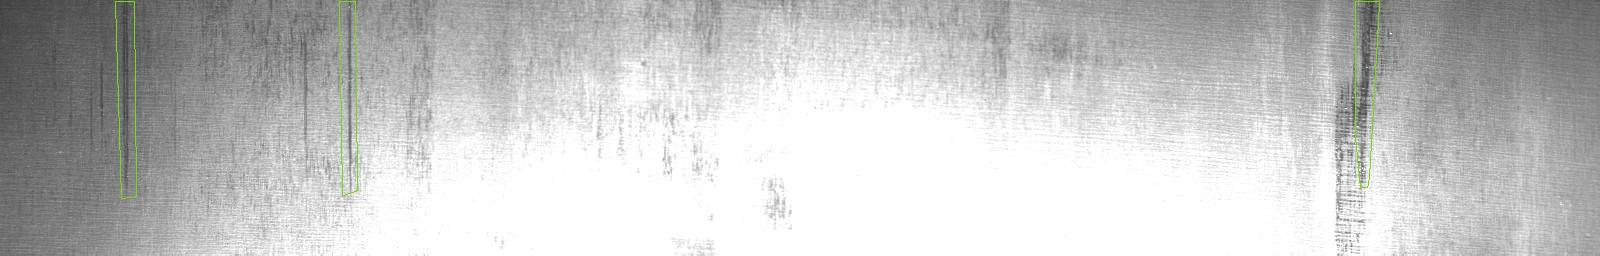

In [10]:
highlight_defect_in_image(image, sample_image, sample_image_id);
# show the resulting image
DisplayImage(filename = image_out.format(sample_image_id), width = image.size[0], height = image.size[1])

In [11]:
del sample_image;
del sample_image_id;

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(15, 2))
for i in range(n_defect_classes):
    ax[i].axis('off')
    ax[i].imshow(np.ones((10, 50, 3), dtype=np.uint8) * defect_class_colors[i])
    ax[i].set_title("Defect class {}".format(i + 1))
fig.suptitle("Defect classes colors")

plt.show()

<Figure size 1500x200 with 4 Axes>

## Flaws examples
Below there are some examples of different images with different combinations of defects.

In [13]:
def images_with_defects(data_set, defect_classes_bitmask, strict = False):
    """
    This calculates the number of images with at least one flaw per each class in defect_classes.
    defect_classes is a bitmask with:
        1 = defect of the i^th class required; 
        0 = if strict: the image must not have the i^th class defect, if not strict: ignore.
    """
    assert defect_classes_bitmask < 2**n_defect_classes, '# defect_classes is {}: check bitmask.'.format(n_defect_classes);
    df = data_set;
    for i in range(n_defect_classes):
        ith_bitmask_value = defect_classes_bitmask & 2**i > 0;
        if strict or ith_bitmask_value == True:
            df = df[df['HasDefect_{}'.format(i + 1)] == ith_bitmask_value];
    return df;

In [14]:
from sklearn.utils import shuffle;

def highlight_defect_in_random_image(dataset):
    sample_image = shuffle(dataset).iloc[0];
    sample_image_id = sample_image['ImageId'];
    print('Processing: {}'.format(sample_image_id));
    image = Image.open(image_in.format(sample_image_id));
    highlight_defect_in_image(image, sample_image, sample_image_id);
    return (sample_image_id, image.size);

In [15]:
def display_random_flawless_surface(dataset, defect_classes, err_msg):
    bitmask = 0;
    for defect_class in defect_classes:
        bitmask = bitmask + 2**(defect_class - 1);
    df = images_with_defects(train_set, bitmask, True);
    if len(df.index) > 0:
        sample_image_filename, sample_image_size = highlight_defect_in_random_image(df);
        display(DisplayImage(filename = image_out.format(sample_image_filename), width = sample_image_size[0], height = sample_image_size[1]))
    else:
        print(err_msg);

#### Example of flawless surfaces

Processing: ba5b942fd.jpg


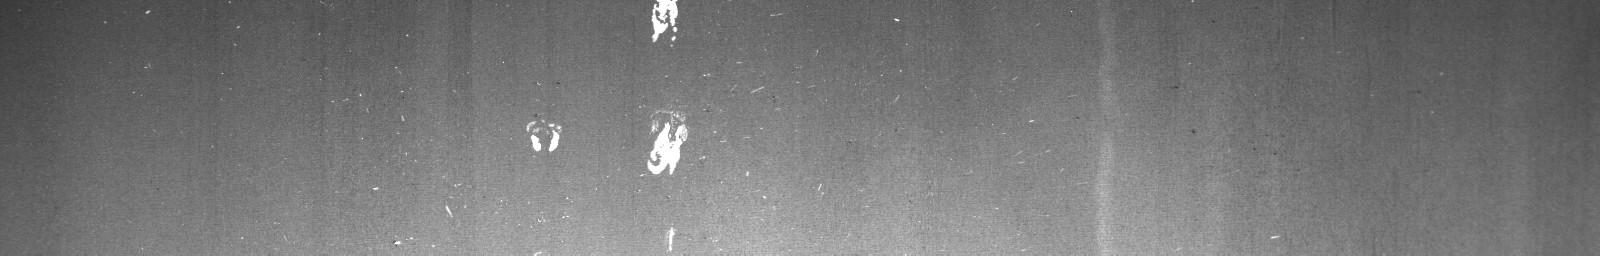

Processing: d5a7bd3de.jpg


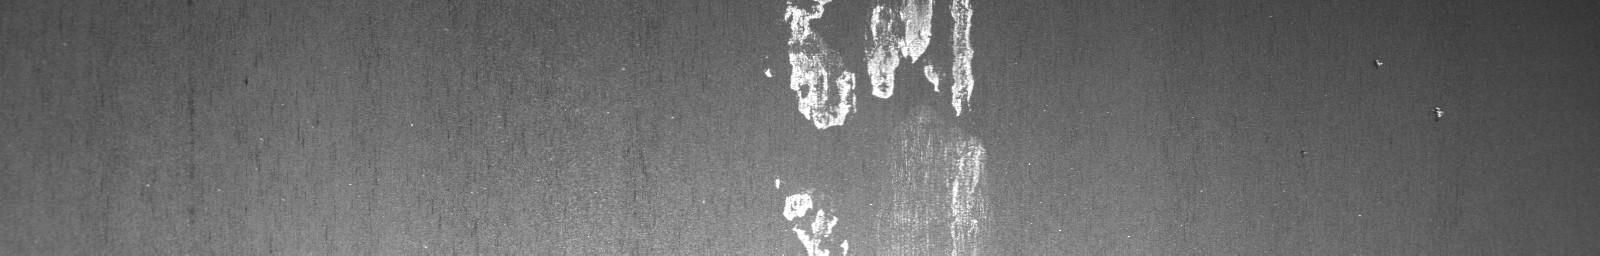

Processing: b83d7659f.jpg


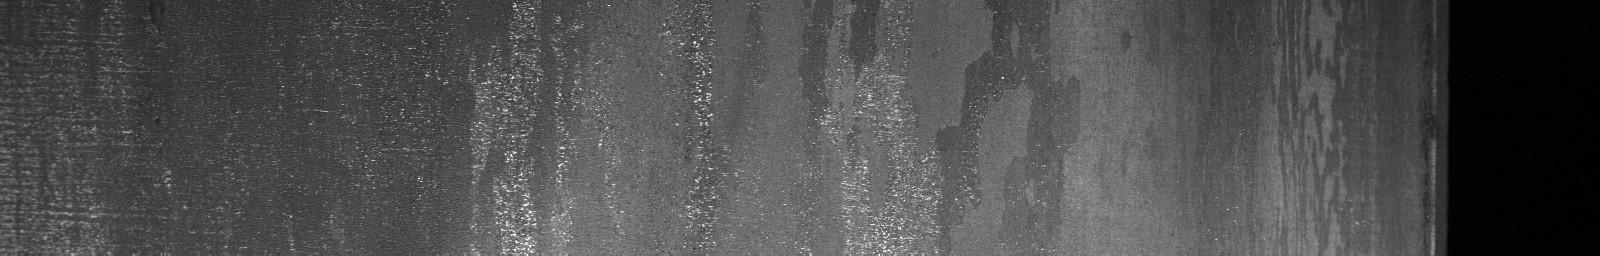

In [16]:
display_random_flawless_surface(train_set, [], 'There are no flawless surface in the training set');
display_random_flawless_surface(cv_set, [], 'There are no flawless surface in the cross validation set');
display_random_flawless_surface(test_set, [], 'There are no flawless surface in the test set');

#### Example of surfaces with only defects of class 1

Processing: 1fd098a38.jpg


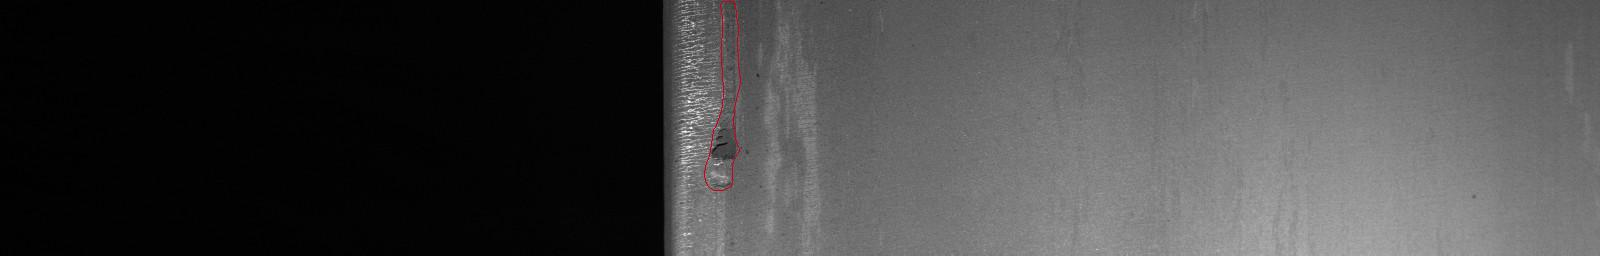

Processing: cd64c39a7.jpg


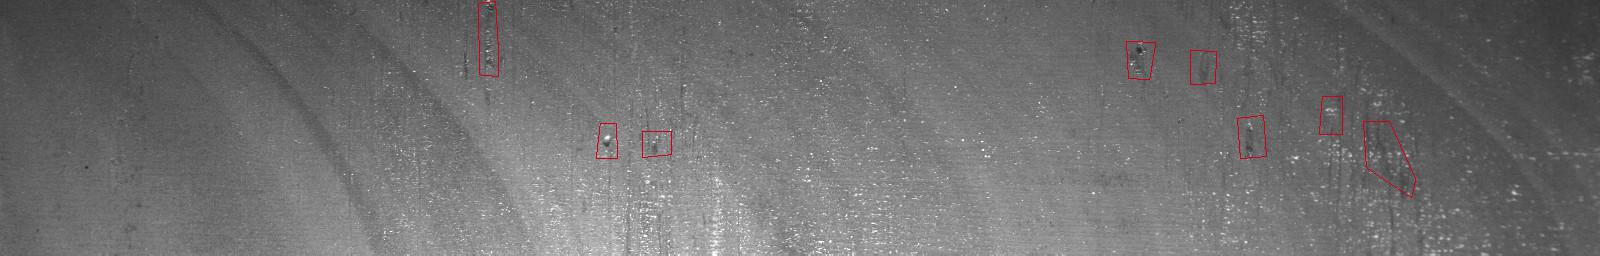

Processing: e848a32dd.jpg


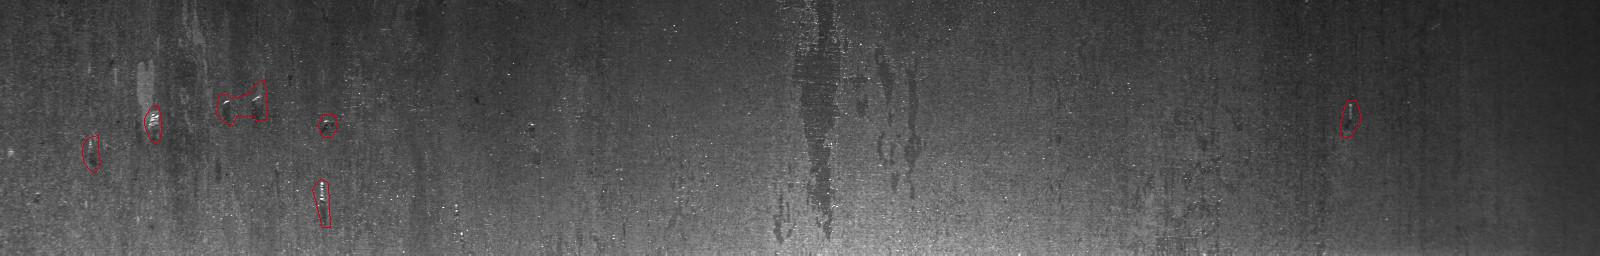

In [17]:
display_random_flawless_surface(train_set, [1], 'There are no surface with only class 1 defects in the training set');
display_random_flawless_surface(cv_set, [1], 'There are no surface with only class 1 defects in the cross validation set');
display_random_flawless_surface(test_set, [1], 'There are no surface with only class 1 defects in the test set');

#### Example of surfaces with only defects of class 2

Processing: 8cc65d1f7.jpg


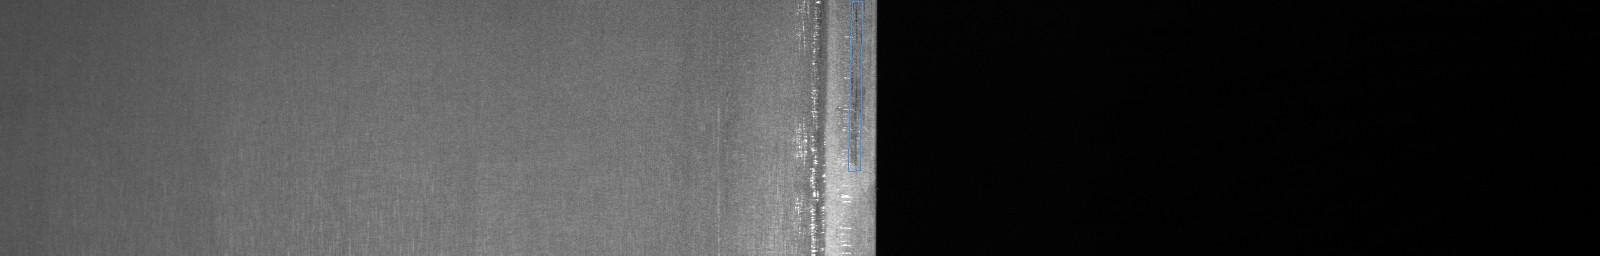

Processing: 18ba753ff.jpg


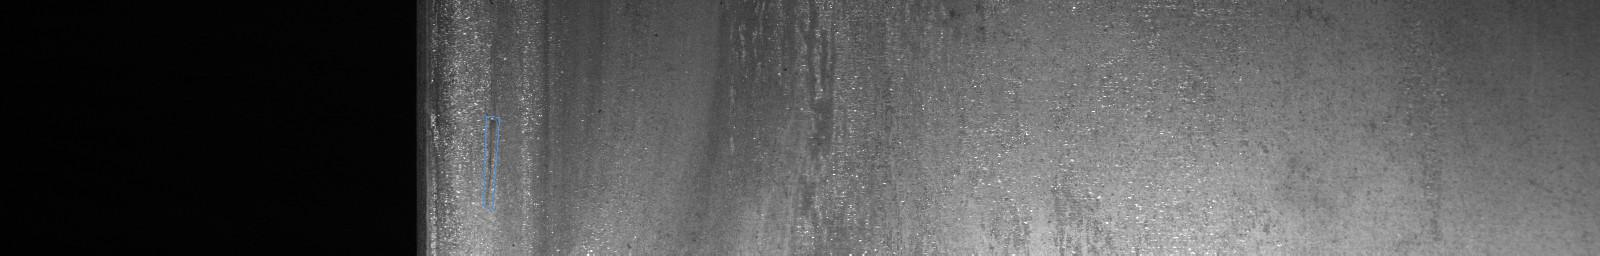

Processing: d67745c5b.jpg


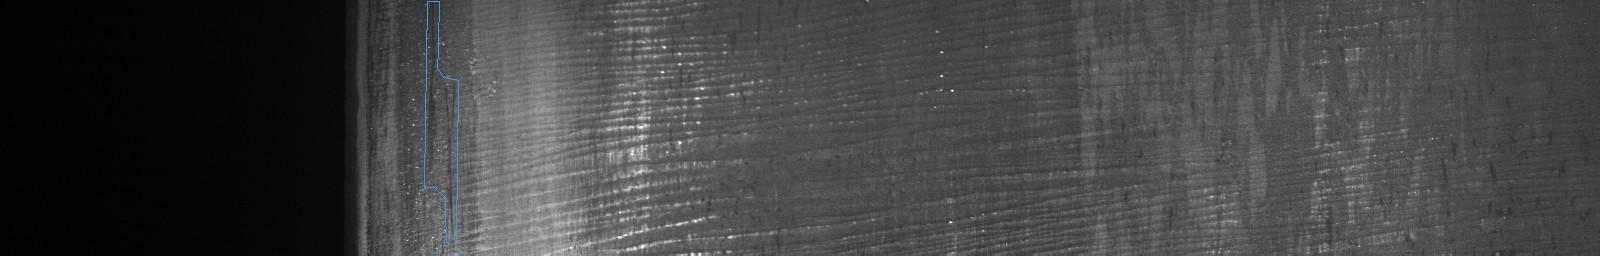

In [18]:
display_random_flawless_surface(train_set, [2], 'There are no surface with only class 2 defects in the training set');
display_random_flawless_surface(cv_set, [2], 'There are no surface with only class 2 defects in the cross validation set');
display_random_flawless_surface(test_set, [2], 'There are no surface with only class 2 defects in the test set');

#### Example of surfaces with only defects of class 3

Processing: eb10d7ae4.jpg


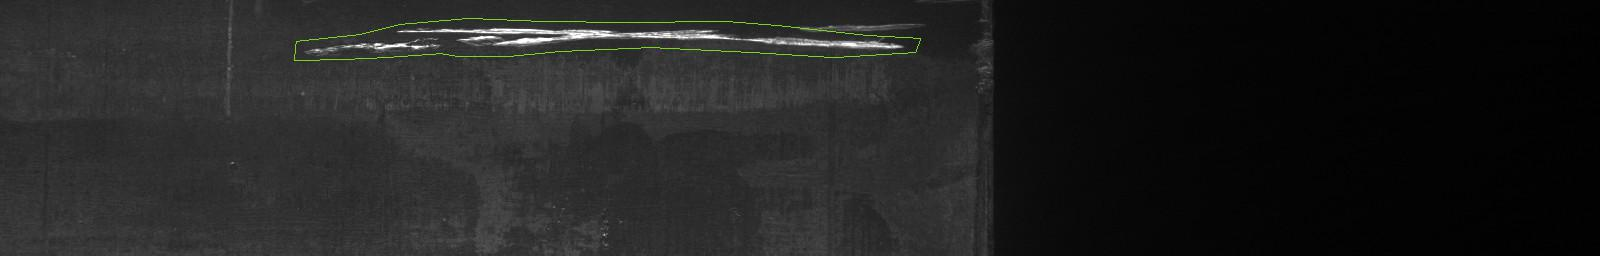

Processing: a6c28501b.jpg


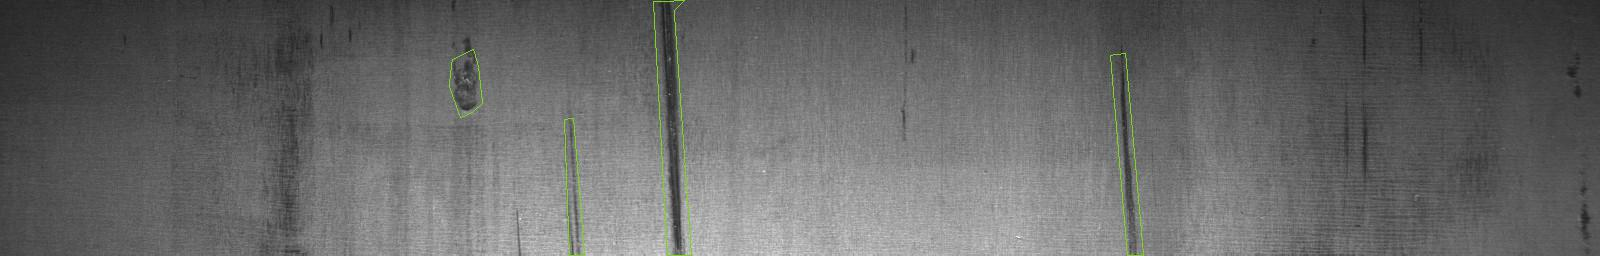

Processing: 10bbf7cb3.jpg


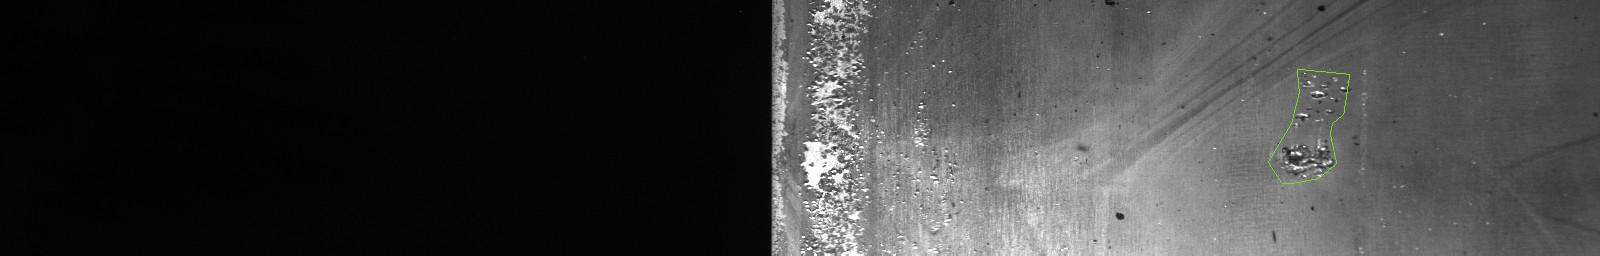

In [19]:
display_random_flawless_surface(train_set, [3], 'There are no surface with only class 3 defects in the training set');
display_random_flawless_surface(cv_set, [3], 'There are no surface with only class 3 defects in the cross validation set');
display_random_flawless_surface(test_set, [3], 'There are no surface with only class 3 defects in the test set');

#### Example of surfaces with only defects of class 4

Processing: 90246e919.jpg


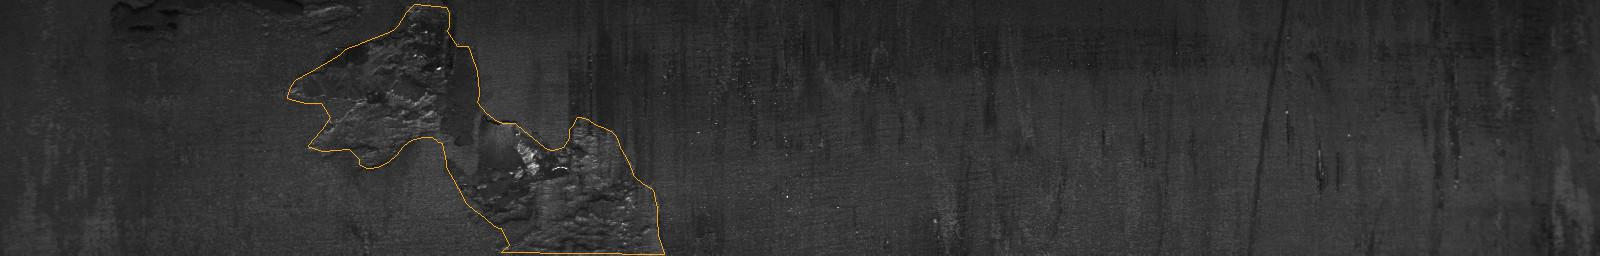

Processing: cd23d4841.jpg


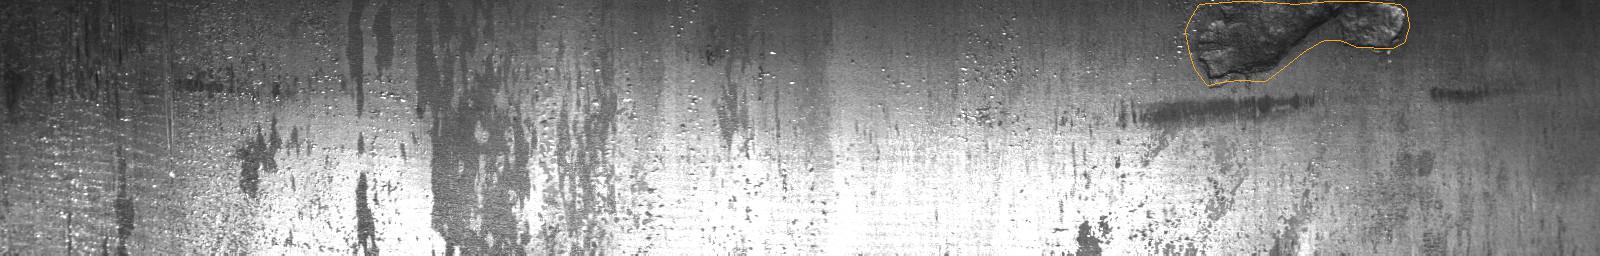

Processing: 9d4b9f63c.jpg


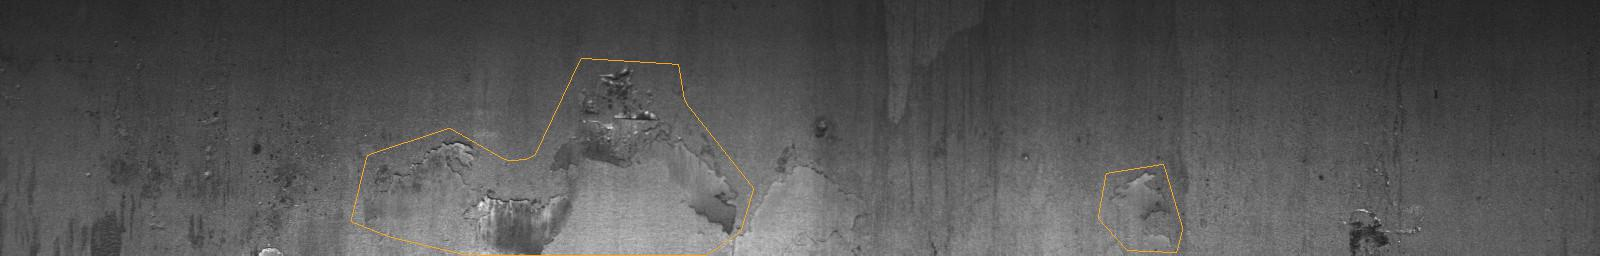

In [20]:
display_random_flawless_surface(train_set, [4], 'There are no surface with only class 4 defects in the training set');
display_random_flawless_surface(cv_set, [4], 'There are no surface with only class 4 defects in the cross validation set');
display_random_flawless_surface(test_set, [4], 'There are no surface with only class 4 defects in the test set');

#### Example of surfaces with only defects of class 1, 2

Processing: 0cb590f8e.jpg


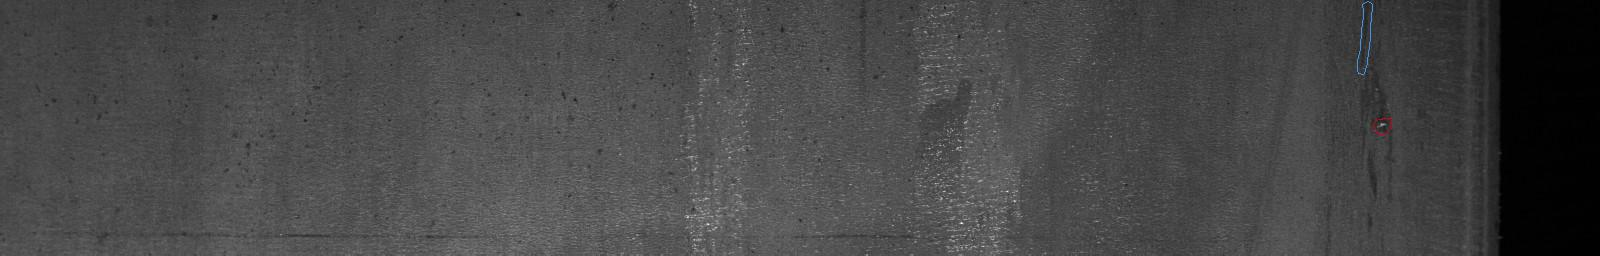

Processing: 2969217e8.jpg


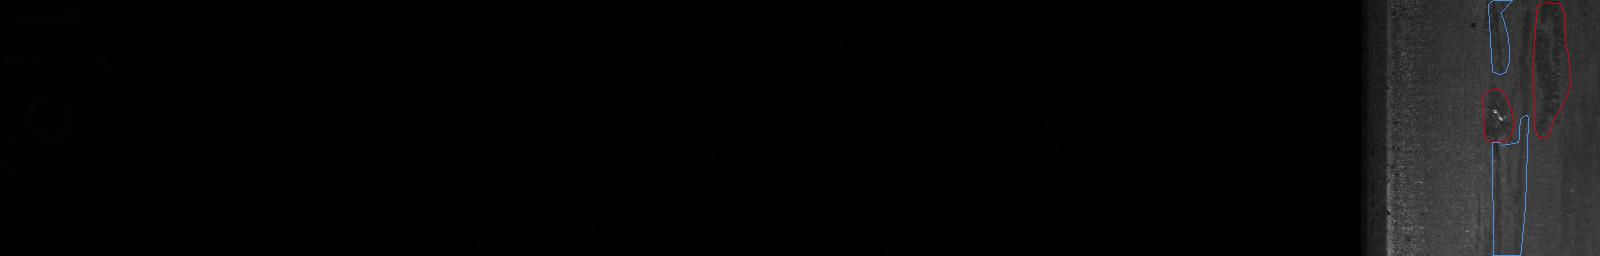

Processing: 0cb590f8e.jpg


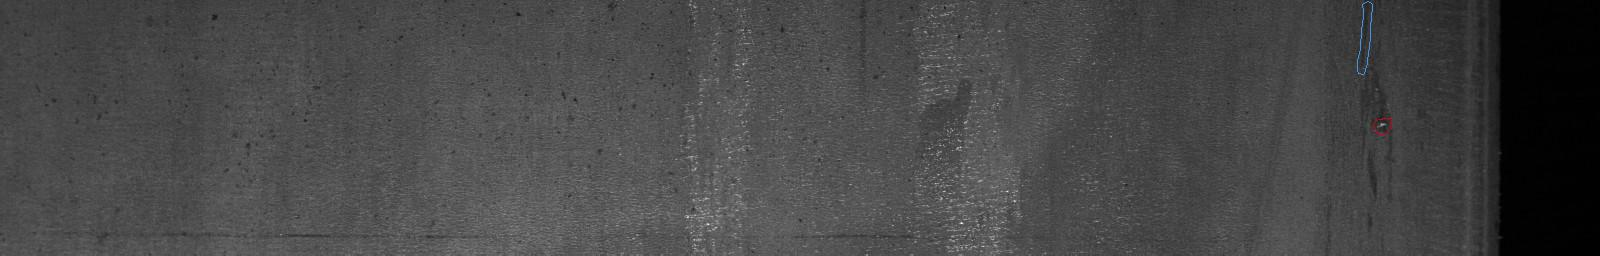

In [21]:
display_random_flawless_surface(train_set, [1, 2], 'There are no surface with only class [1, 2] defects in the training set');
display_random_flawless_surface(cv_set, [1, 2], 'There are no surface with only class [1, 2] defects in the cross validation set');
display_random_flawless_surface(test_set, [1, 2], 'There are no surface with only class [1, 2] defects in the test set');

#### Example of surfaces with only defects of class 1, 3

Processing: 27f44281b.jpg


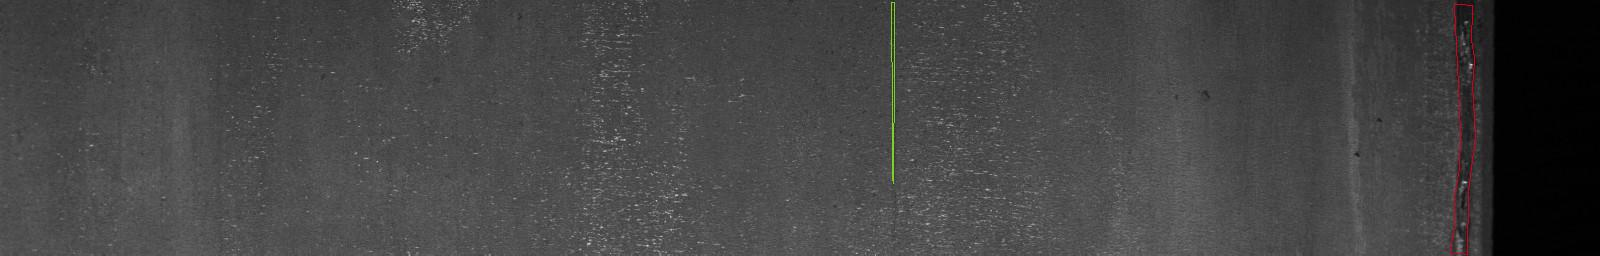

Processing: 6c011fc34.jpg


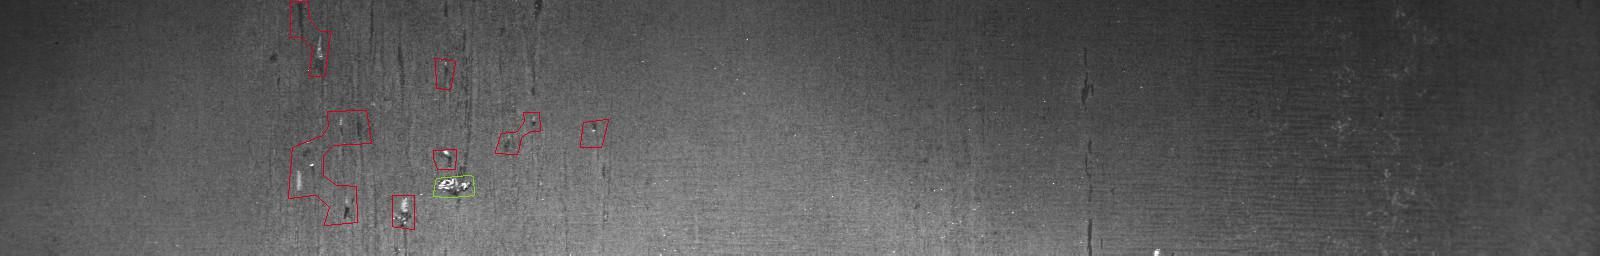

Processing: 268f0fa63.jpg


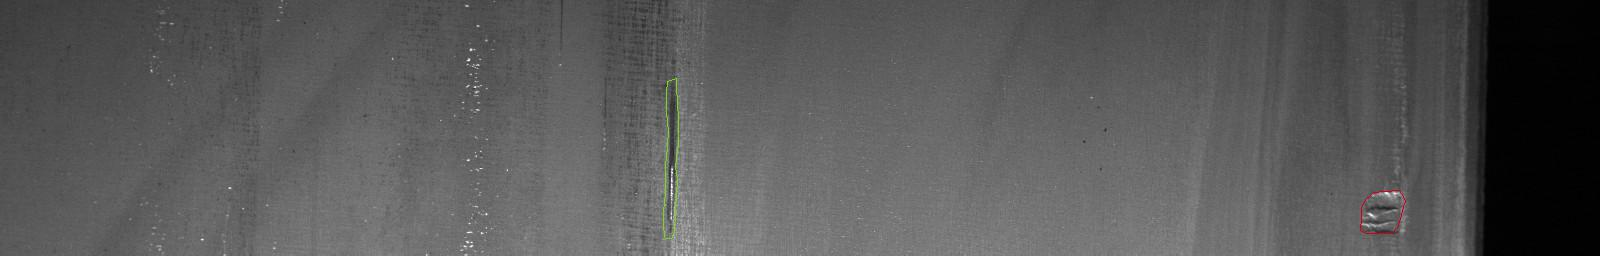

In [22]:
display_random_flawless_surface(train_set, [1, 3], 'There are no surface with only class [1, 3] defects in the training set');
display_random_flawless_surface(cv_set, [1, 3], 'There are no surface with only class [1, 3] defects in the cross validation set');
display_random_flawless_surface(test_set, [1, 3], 'There are no surface with only class [1, 3] defects in the test set');

#### Example of surfaces with only defects of class 1, 4

In [23]:
display_random_flawless_surface(train_set, [1, 4], 'There are no surface with only class [1, 4] defects in the training set');
display_random_flawless_surface(cv_set, [1, 4], 'There are no surface with only class [1, 4] defects in the cross validation set');
display_random_flawless_surface(test_set, [1, 4], 'There are no surface with only class [1, 4] defects in the test set');

There are no surface with only class [1, 4] defects in the training set
There are no surface with only class [1, 4] defects in the cross validation set
There are no surface with only class [1, 4] defects in the test set


#### Example of surfaces with only defects of class 2, 3

Processing: 101648543.jpg


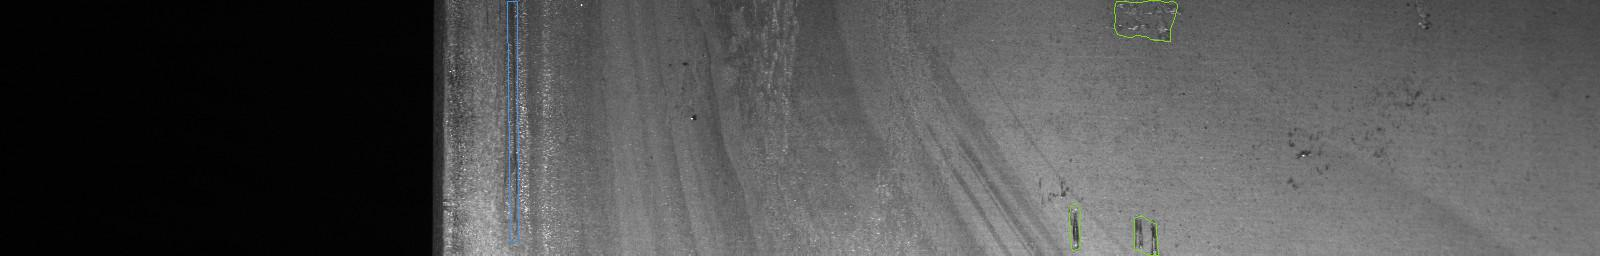

Processing: 6fdf2d1be.jpg


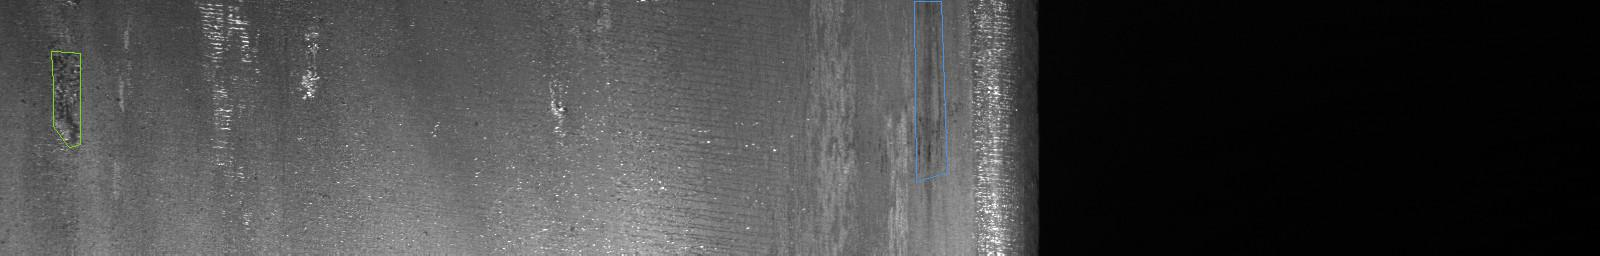

Processing: 6fdf2d1be.jpg


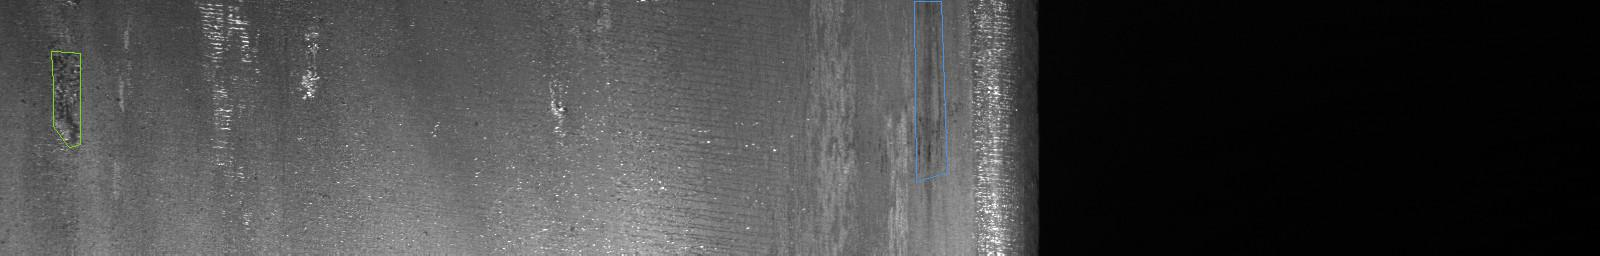

In [24]:
display_random_flawless_surface(train_set, [2, 3], 'There are no surface with only class [2, 3] defects in the training set');
display_random_flawless_surface(cv_set, [2, 3], 'There are no surface with only class [2, 3] defects in the cross validation set');
display_random_flawless_surface(test_set, [2, 3], 'There are no surface with only class [2, 3] defects in the test set');

#### Example of surfaces with only defects of class 2,4

Processing: ac6367260.jpg


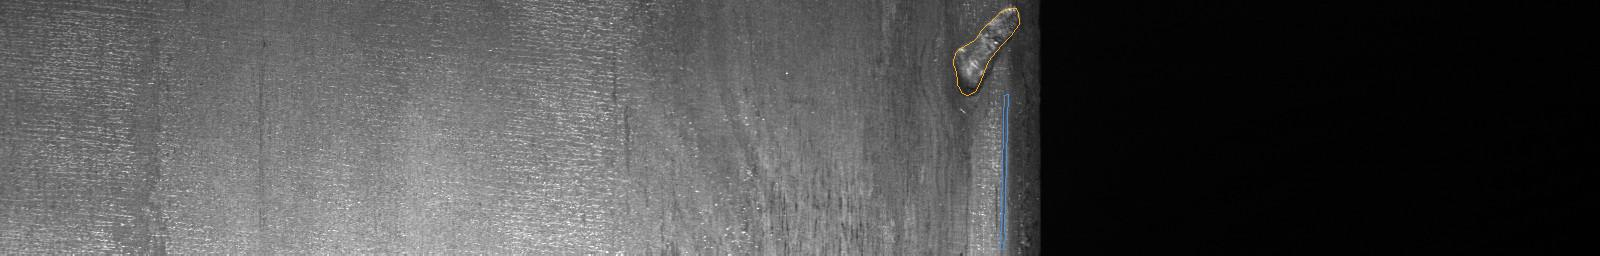

Processing: ac6367260.jpg


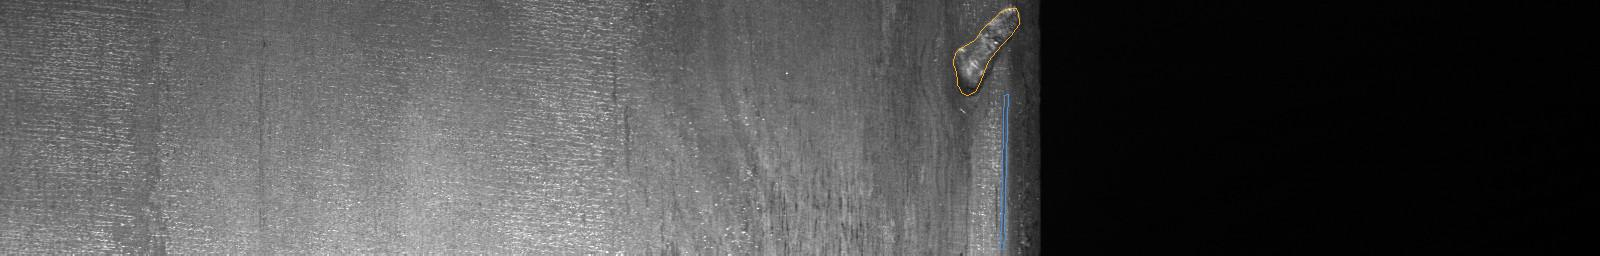

Processing: ac6367260.jpg


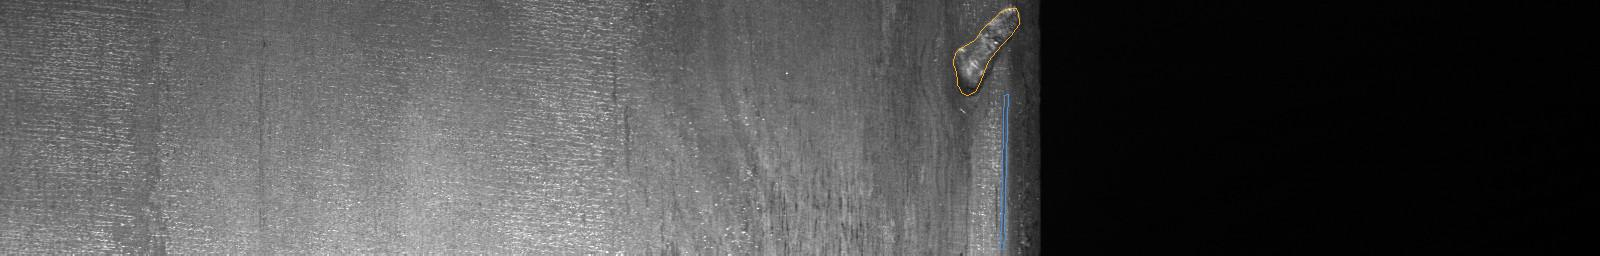

In [25]:
display_random_flawless_surface(train_set, [2, 4], 'There are no surface with only class [2, 4] defects in the training set');
display_random_flawless_surface(cv_set, [2, 4], 'There are no surface with only class [2, 4] defects in the cross validation set');
display_random_flawless_surface(test_set, [2, 4], 'There are no surface with only class [2, 4] defects in the test set');

#### Example of surfaces with only defects of class 3, 4

Processing: f6f7902a9.jpg


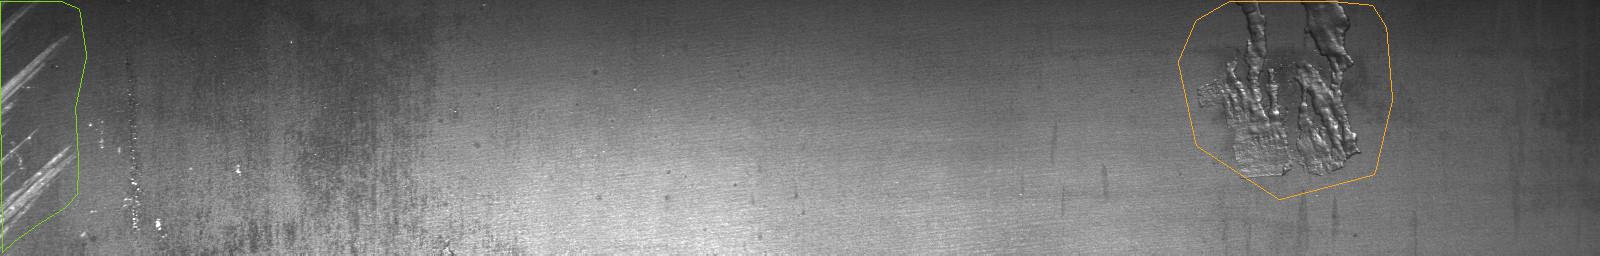

Processing: 7c83d2da1.jpg


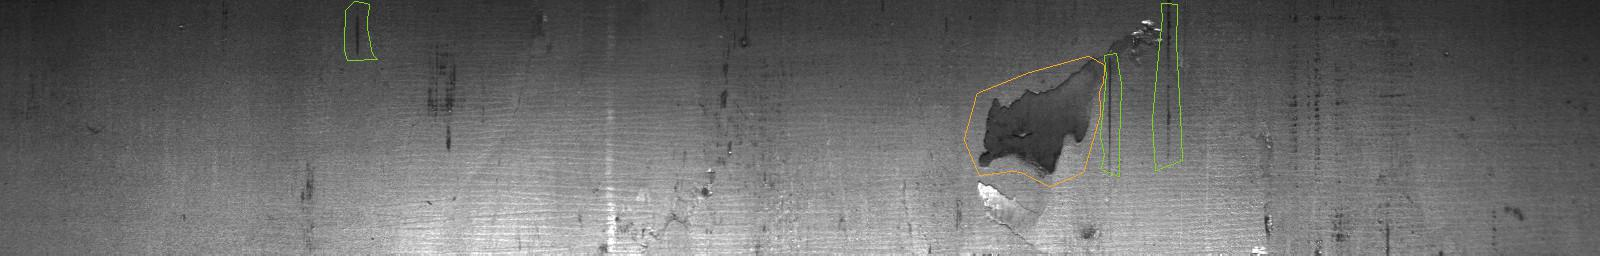

Processing: c7aeb9c82.jpg


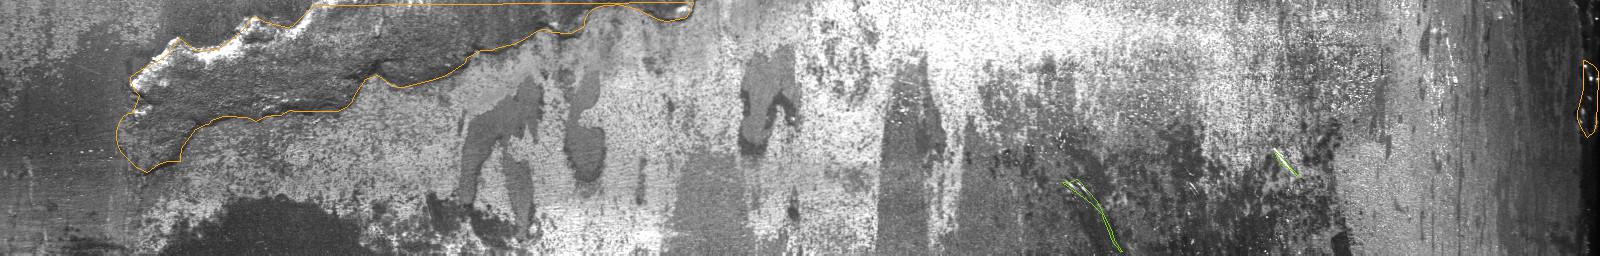

In [26]:
display_random_flawless_surface(train_set, [3, 4], 'There are no surface with only class [3, 4] defects in the training set');
display_random_flawless_surface(cv_set, [3, 4], 'There are no surface with only class [3, 4] defects in the cross validation set');
display_random_flawless_surface(test_set, [3, 4], 'There are no surface with only class [3, 4] defects in the test set');

#### Example of surfaces with only defects of class 1, 2, 3

Processing: ef24da2ba.jpg


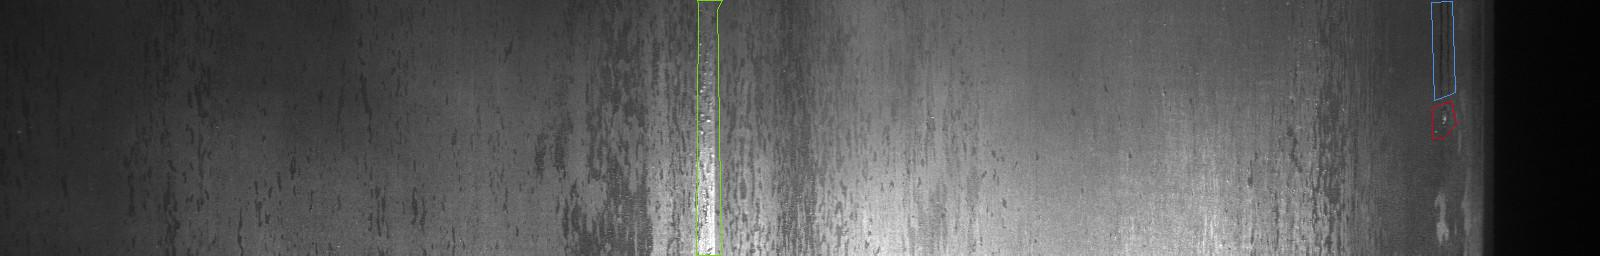

Processing: ef24da2ba.jpg


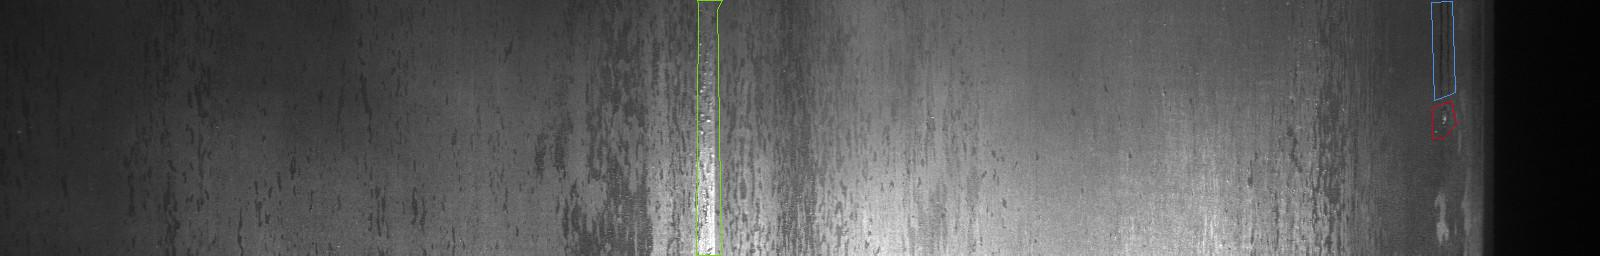

Processing: db4867ee8.jpg


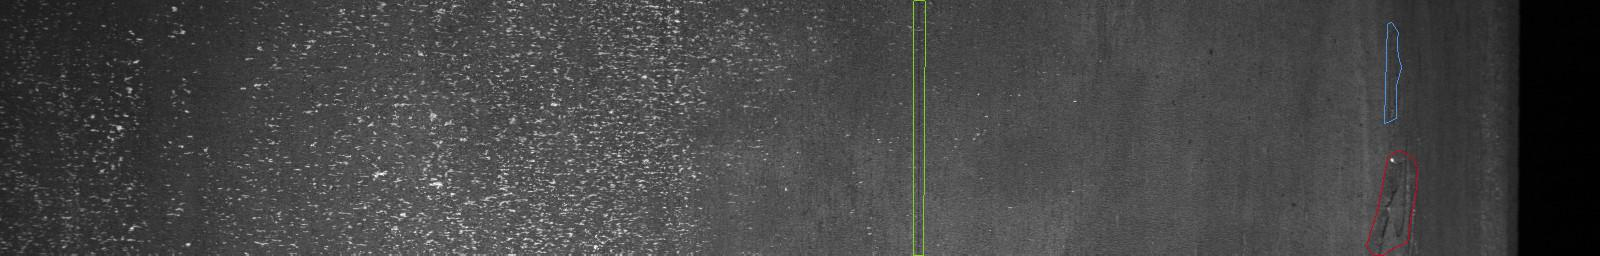

In [27]:
display_random_flawless_surface(train_set, [1, 2, 3], 'There are no surface with only class [1, 2, 3] defects in the training set');
display_random_flawless_surface(cv_set, [1, 2, 3], 'There are no surface with only class [1, 2, 3] defects in the cross validation set');
display_random_flawless_surface(test_set, [1, 2, 3], 'There are no surface with only class [1, 2, 3] defects in the test set');

#### Example of surfaces with only defects of class 1, 2, 4

In [28]:
display_random_flawless_surface(train_set, [1, 2, 4], 'There are no surface with only class [1, 2, 4] defects in the training set');
display_random_flawless_surface(cv_set, [1, 2, 4], 'There are no surface with only class [1, 2, 4] defects in the cross validation set');
display_random_flawless_surface(test_set, [1, 2, 4], 'There are no surface with only class [1, 2, 4] defects in the test set');

There are no surface with only class [1, 2, 4] defects in the training set
There are no surface with only class [1, 2, 4] defects in the cross validation set
There are no surface with only class [1, 2, 4] defects in the test set


#### Example of surfaces with only defects of class 1, 3, 4

In [29]:
display_random_flawless_surface(train_set, [1, 3, 4], 'There are no surface with only class [1, 3, 4] defects in the training set');
display_random_flawless_surface(cv_set, [1, 3, 4], 'There are no surface with only class [1, 3, 4] defects in the cross validation set');
display_random_flawless_surface(test_set, [1, 3, 4], 'There are no surface with only class [1, 3, 4] defects in the test set');

There are no surface with only class [1, 3, 4] defects in the training set
There are no surface with only class [1, 3, 4] defects in the cross validation set
There are no surface with only class [1, 3, 4] defects in the test set


#### Example of surfaces with only defects of class 2, 3, 4

In [30]:
display_random_flawless_surface(train_set, [2, 3, 4], 'There are no surface with only class [2, 3, 4] defects in the training set');
display_random_flawless_surface(cv_set, [2, 3, 4], 'There are no surface with only class [2, 3, 4] defects in the cross validation set');
display_random_flawless_surface(test_set, [2, 3, 4], 'There are no surface with only class [2, 3, 4] defects in the test set');

There are no surface with only class [2, 3, 4] defects in the training set
There are no surface with only class [2, 3, 4] defects in the cross validation set
There are no surface with only class [2, 3, 4] defects in the test set


#### Example of surfaces with only defects of class 1, 2, 3, 4

In [31]:
display_random_flawless_surface(train_set, [1, 2, 3, 4], 'There are no surface with only class [1, 2, 3, 4] defects in the training set');
display_random_flawless_surface(cv_set, [1, 2, 3, 4], 'There are no surface with only class [1, 2, 3, 4] defects in the cross validation set');
display_random_flawless_surface(test_set, [1, 2, 3, 4], 'There are no surface with only class [1, 2, 3, 4] defects in the test set');

There are no surface with only class [1, 2, 3, 4] defects in the training set
There are no surface with only class [1, 2, 3, 4] defects in the cross validation set
There are no surface with only class [1, 2, 3, 4] defects in the test set


**TODO:** 
1. Sizing CNN layers based on flaws.
2. Normalize brightness

## Statistics on the dataset
Below we will provide some analysis on the dataset.

In [32]:
def calculate_statistics(data_set, strict = False):
    n_images = len(data_set.index);
    statistics = {};
    
    def calculate_statistic(bitmask):
        image_with_bitmask_defect = images_with_defects(data_set, bitmask, strict);
        return len(image_with_bitmask_defect.index);

    def permute(bitmask, i):
        # calculate all dispositions of defects
        if i < n_defect_classes:
            bitmask = bitmask & ~2**i;
            permute(bitmask, i + 1);
            bitmask = bitmask | 2**i;
            permute(bitmask, i + 1);
        else:
            statistics[bitmask] = calculate_statistic(bitmask);
    
    permute(0, 0);
    statistics[0] = len(images_with_defects(data_set, 0, True).index);
    
    return statistics;

In [33]:
# some utils

def take_k_out_of_n(k, n):
    bitmasks = [];
    def combine(bitmask, i, n, m):
        if m == 0:
            bitmasks.append(bitmask);
        elif i < n:
            bitmask = bitmask & ~2**i;
            combine(bitmask, i + 1, n, m);
            bitmask = bitmask | 2**i;
            combine(bitmask, i + 1, n, m - 1);
    combine(0, 0, n, k);
    all_combinations = [];
    for bitmask in bitmasks:
        ks = [];
        for i in range(0, n):
            if bitmask & 2**i > 0:
                ks.append(i + 1);
        all_combinations.append(ks);
    return all_combinations;

def binary_to_decimal(binary_pos):
                dec = 0;
                for pos in binary_pos:
                    dec = dec + 2**(pos - 1);
                return dec;

In [34]:
def plot_dataset_statistics(datasets, set_labels, colors, normalize = True, consider_combinations = False, auto_label = True):
    n_datasets = len(datasets)
    assert n_datasets == len(set_labels), 'Each dataset must have its label';
    assert n_datasets == len(colors), 'Each dataset must have its color_set';
    
    labels = ['Flawless surfaces', 
              *['Surfaces with defect class {}'.format(class_id) for class_id in range(1, n_defect_classes + 1)]];
    
    if consider_combinations:
        for n_tuple in range(2, n_defect_classes + 1):
            labels = [
                *labels,
                *['Surfaces with defect classes: {}'.format(combination) 
                       for combination in take_k_out_of_n(n_tuple, n_defect_classes)]
            ];

    x = np.arange(len(labels));  # the label locations
    width = 1;  # the width of the bars

    fig, ax = plt.subplots();

    bars = [];
    
    def df_bars(df, set_label, color_list, width, shift):
        _stats = calculate_statistics(df, consider_combinations);
        if normalize:
            _stats = { key: value / len(df.index) for key, value in _stats.items() };
        stats = [_stats[0], *[_stats[2**i] for i in range(0, n_defect_classes)]];
        if consider_combinations:
            for n_tuple in range(2, n_defect_classes + 1):
                stats = [
                    *stats,
                    *[_stats[binary_to_decimal(combination)] 
                      for combination in take_k_out_of_n(n_tuple, n_defect_classes)]
                ];
            bars.append(ax.barh(x + shift * width, stats, width, label = set_label));
        else:
            bars.append(ax.bar(x + shift * width, stats, width, label = set_label));
    
    x_begin = - (n_datasets - 1) / n_datasets;
    x_skip = 2 / n_datasets;
    x_shifts = [x_begin + i * x_skip for i in range(0, n_datasets)];
    
    for i in range(0, n_datasets):
        df_bars(datasets[i], set_labels[i], colors[i], width / n_datasets, x_shifts[i]);
    
    if auto_label and not consider_combinations:
        def autolabel(rects):
            # Attach a text label above each bar in *rects*, displaying its height.
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        for rects in bars:
            autolabel(rects);
    
    
    # set title, axis labels, ..
    ax.set_title('Dataset statistics on defect classes.')
    ax.legend()
    
    ylabel = '#Images';
    if normalize:
        ylabel = '#Images (%)'
    
    if consider_combinations:
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel(ylabel)
        ax.set_yticks(x)
        ax.set_yticklabels(labels)
    else:
        ax.set_ylabel(ylabel)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        
    # layout
    fig.set_figwidth(15);
    fig.set_figheight(7);
    fig.tight_layout()

    plt.show()

Absolute value statistics in the training, cross validation and test sets:

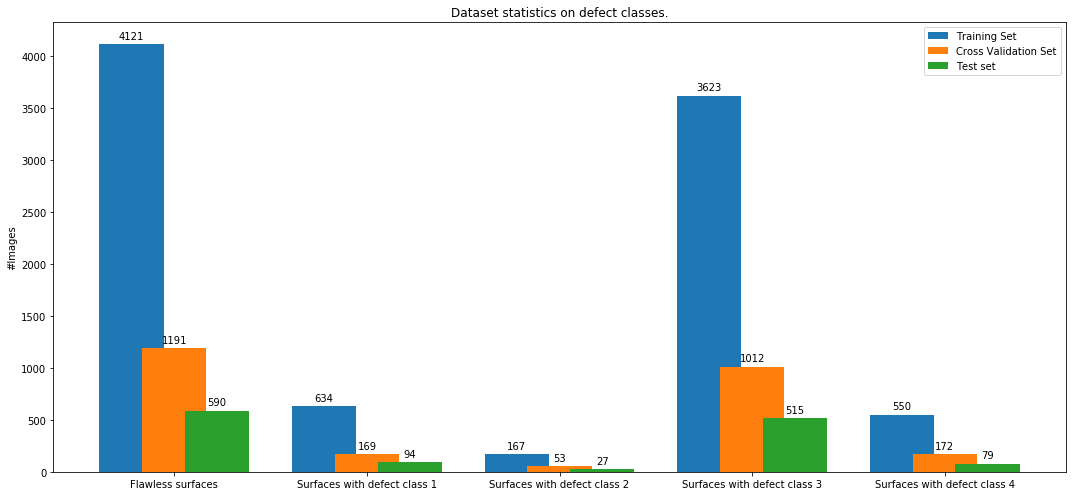

In [35]:
plot_dataset_statistics(
    [ train_set, cv_set, test_set ], 
    ['Training Set', 'Cross Validation Set', 'Test set'], 
    [[(0,0,0), *defect_class_colors_01], [(0,0,0), *defect_class_colors_01], [(0,0,0), *defect_class_colors_01]],
    False)

Relative value statistics in the training, cross validation and test sets:

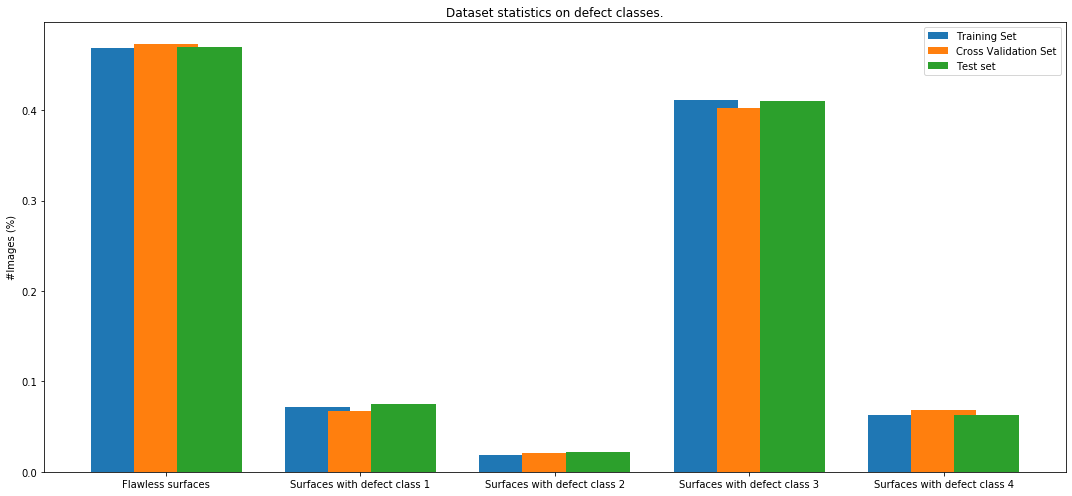

In [36]:
plot_dataset_statistics(
    [ train_set, cv_set, test_set ], 
    ['Training Set', 'Cross Validation Set', 'Test set'], 
    [[(0,0,0), *defect_class_colors_01], [(0,0,0), *defect_class_colors_01], [(0,0,0), *defect_class_colors_01]],
    True, False, False)

### Remarks
**Remark.1:** We observe immediately that the random sampling worked well, in the sense that all the classes have the same proportion in the training, cross validation and test sets.

**Remark.2:** We observe also that the the defects of 3^rd class are the most common, and equiparable in number to the flawless surfaces. We can see that the dataset is really skewed, so we will consider data augmentation tecniques.

### More statistics
Below we see all the combinations of defects and their proportion inside tha dataset in absolute value (number of images) and relative value (%).

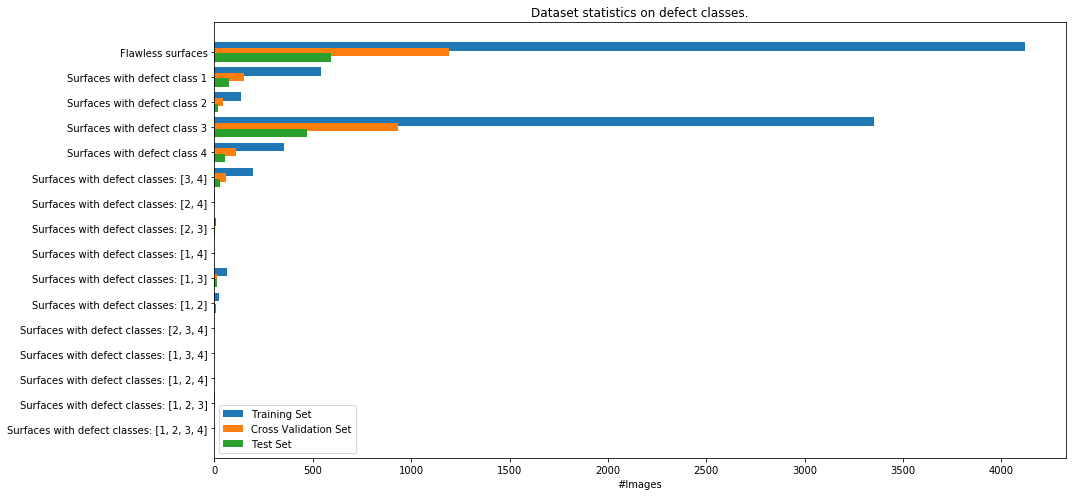

In [37]:
plot_dataset_statistics(
    [ train_set, cv_set, test_set ], 
    ['Training Set', 'Cross Validation Set', 'Test Set'], 
    [[(0,0,0), *defect_class_colors_01], [(0,0,0), *defect_class_colors_01], [(0,0,0), *defect_class_colors_01]],
    False, True)

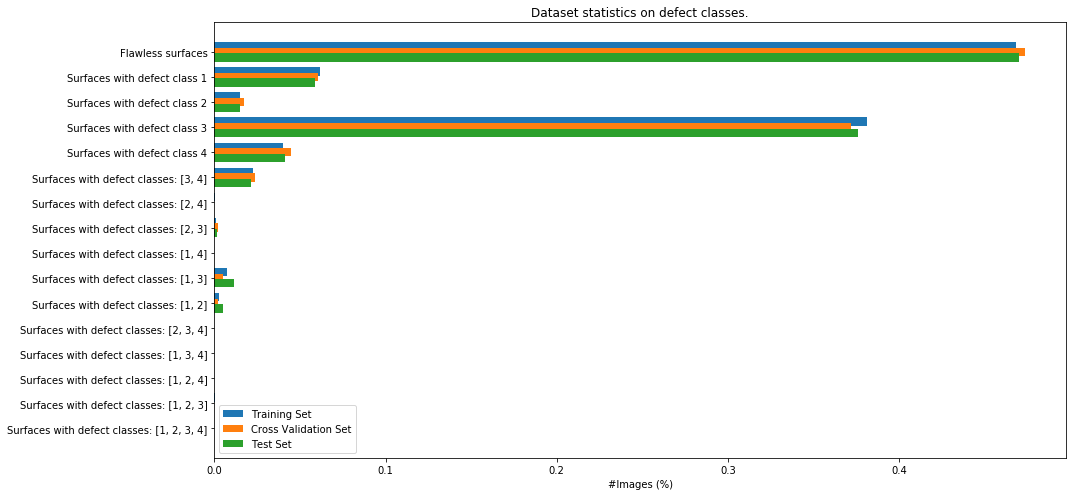

In [38]:
plot_dataset_statistics(
    [ train_set, cv_set, test_set ], 
    ['Training Set', 'Cross Validation Set', 'Test Set'], 
    [[(0,0,0), *defect_class_colors_01], [(0,0,0), *defect_class_colors_01], [(0,0,0), *defect_class_colors_01]],
    True, True)

From the above bar chart, we can see that the only noticeable couple is the one formed by the defect classes 3 and 4; in general, the probability of having more than one flaw on a surface is:

In [39]:
train_set_stats = calculate_statistics(train_set, True);
n_surfaces_0_1_flaws = train_set_stats[0];
for i in range(0, n_defect_classes):
    n_surfaces_0_1_flaws = n_surfaces_0_1_flaws + train_set_stats[2**i];
print('P[#flaws > 1] = {}'.format(1 - n_surfaces_0_1_flaws / len(train_set.index)))

P[#flaws > 1] = 0.033647834489030304


This observation lead us to consider two different approaches:
1. Ignore multiple flaws on the same surface and train a single network for each defect class;
2. Apply data augmentation tecniques to balance the dataset.

We will start with the first approach (easier) and consider the second later.

**Remark:** if the classifier fails to classify, for example, the surfaces with defect classes [2,3], maybe it is better to manually put those surfaces in the training, cross validation and test sets.